In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification

In [18]:
from transformers import logging
logging.set_verbosity_error()

In [2]:
df = pd.read_csv('https://github.com/clairett/pytorch-sentiment-classification/raw/master/data/SST2/train.tsv', delimiter='\t', header=None)

In [6]:
df.head()

,0,1
0,"a stirring , funny and finally transporting re...",1
1,apparently reassembled from the cutting room f...,0
2,they presume their audience wo n't sit still f...,0
3,this is a visually stunning rumination on love...,1
4,jonathan parker 's bartleby should have been t...,1


In [7]:
labels = df[1].values

In [8]:
from tensorflow.keras.utils import to_categorical
y_one_hot = to_categorical(labels)

In [9]:
texts = df[0].values.tolist()

In [12]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(texts, y_one_hot, test_size=0.2, random_state=0)

In [13]:
X_train_tokenized = tokenizer(X_train, return_tensors="np", max_length=30, padding='max_length', truncation=True)
X_test_tokenized = tokenizer(X_test, return_tensors="np", max_length=30, padding='max_length', truncation=True)

In [10]:
X_train_tokenized

{'input_ids': array([[ 101, 2856, 2011, ..., 5525, 2928,  102],
       [ 101, 1037, 6171, ...,    0,    0,    0],
       [ 101, 2005, 2216, ..., 4566, 2003,  102],
       ...,
       [ 101, 2004, 2005, ...,    0,    0,    0],
       [ 101, 2009, 2089, ...,    0,    0,    0],
       [ 101, 1996, 2143, ...,    0,    0,    0]]), 'token_type_ids': array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]]), 'attention_mask': array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])}

In [11]:
type(X_train_tokenized)

transformers.tokenization_utils_base.BatchEncoding

In [19]:
model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

조기종료를 사용하지 않는 경우

In [15]:
optimizer = tf.keras.optimizers.Adam(2e-5)
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [16]:
history = model.fit(dict(X_train_tokenized), y_train, epochs=5, batch_size=128, validation_split=0.1)

Epoch 1/5
39/39 [==============================] - 797s 20s/step - loss: 0.5637 - accuracy: 0.7565 - val_loss: 0.4354 - val_accuracy: 0.8213
Epoch 2/5
39/39 [==============================] - 758s 19s/step - loss: 0.3155 - accuracy: 0.8866 - val_loss: 0.3109 - val_accuracy: 0.8755
Epoch 3/5
39/39 [==============================] - 812s 21s/step - loss: 0.1841 - accuracy: 0.9426 - val_loss: 0.3146 - val_accuracy: 0.8809
Epoch 4/5
39/39 [==============================] - 827s 21s/step - loss: 0.1147 - accuracy: 0.9663 - val_loss: 0.3521 - val_accuracy: 0.8718
Epoch 5/5
39/39 [==============================] - 856s 22s/step - loss: 0.0776 - accuracy: 0.9799 - val_loss: 0.3600 - val_accuracy: 0.8917


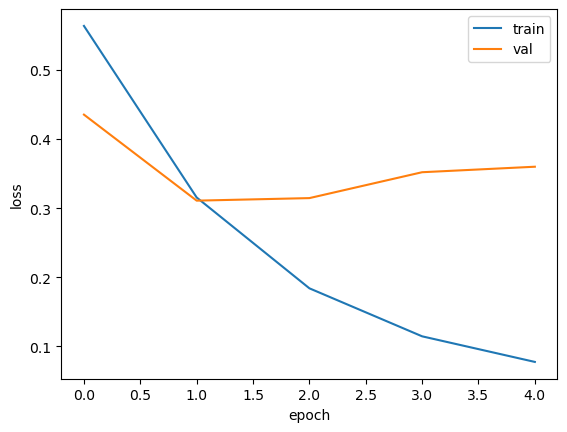

In [17]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'])
plt.show()


In [18]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
checkpoint_filepath = "./checkpoints/checkpoint_bert_en"
mc = ModelCheckpoint(checkpoint_filepath, monitor='val_loss', mode='min', 
                     save_best_only=True,
                     save_weights_only=True,
    )

In [19]:
history = model.fit(dict(X_train_tokenized), y_train, epochs=5, batch_size=128, validation_split=0.1,
                   callbacks=[es, mc])

Epoch 1/5
39/39 [==============================] - 670s 17s/step - loss: 0.1750 - accuracy: 0.9438 - val_loss: 0.3130 - val_accuracy: 0.8917
Epoch 2/5
39/39 [==============================] - 687s 18s/step - loss: 0.1111 - accuracy: 0.9703 - val_loss: 0.3702 - val_accuracy: 0.8809
Epoch 2: early stopping


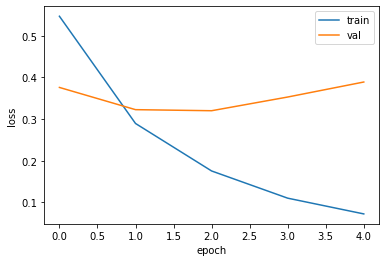

In [31]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'])
plt.show()

In [20]:
model.load_weights(checkpoint_filepath)
model.evaluate(dict(X_test_tokenized), y_test)

44/44 [==============================] - 52s 1s/step - loss: 0.2748 - accuracy: 0.9053


[0.2747797667980194, 0.9053468108177185]

In [21]:
y_preds = model.predict(dict(X_test_tokenized))

44/44 [==============================] - 55s 1s/step


In [22]:
len(y_preds)

1

In [23]:
len(y_preds.logits)

1384

In [24]:
y_preds

TFSequenceClassifierOutput(loss=None, logits=array([[ 2.7235675, -2.9032316],
       [ 3.4308157, -3.4531446],
       [-3.98268  ,  4.0701356],
       ...,
       [-4.000534 ,  4.1408625],
       [-3.7012453,  3.7606502],
       [-2.7384   ,  2.7000008]], dtype=float32), hidden_states=None, attentions=None)

In [25]:
prediction_probs = tf.nn.softmax(y_preds.logits,axis=1).numpy()

In [26]:
prediction_probs

array([[9.9641281e-01, 3.5871663e-03],
       [9.9897695e-01, 1.0230327e-03],
       [3.1810359e-04, 9.9968195e-01],
       ...,
       [2.9114541e-04, 9.9970883e-01],
       [5.7423615e-04, 9.9942577e-01],
       [4.3276194e-03, 9.9567246e-01]], dtype=float32)

In [27]:
y_predictions = np.argmax(prediction_probs, axis=1)

In [28]:
y_predictions

array([0, 0, 1, ..., 1, 1, 1], dtype=int64)

In [29]:
y_test = np.argmax(y_test, axis=1)

In [30]:
from sklearn.metrics import classification_report
print(classification_report(y_predictions, y_test))

              precision    recall  f1-score   support

           0       0.90      0.90      0.90       651
           1       0.91      0.91      0.91       733

    accuracy                           0.91      1384
   macro avg       0.91      0.90      0.90      1384
weighted avg       0.91      0.91      0.91      1384

